<a href="https://colab.research.google.com/github/matthewreader/continuous-learning/blob/main/books/deep-learning-with-pytorch/Deep_Learning_with_PyTorch_Chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from google.colab import drive
from torchvision import datasets

drive.mount('/content/gdrive')
GDRIVE_DATA = "gdrive/My Drive/Colab Notebooks/Data/deep-learning-with-pytorch"

data_path = GDRIVE_DATA + '/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Mounted at /content/gdrive
Files already downloaded and verified
Files already downloaded and verified


Get one image from the data set and transform to a tensor

In [ ]:
from torchvision import transforms
img, label = cifar10[99]

In [ ]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

Transform the entire dataset to a tensor

In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                         transform=transforms.ToTensor())

# Validation set also needs to be tensor, not part of book follow-along code
tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                         transform=transforms.ToTensor())

In [ ]:
# Tensors instead of PIL images, also scales values down to 0.0 to 1.0
img_t, _ = tensor_cifar10[99]
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [ ]:
img_t

tensor([[[0.2431, 0.1961, 0.1804,  ..., 0.6549, 0.7176, 0.5373],
         [0.2471, 0.2157, 0.2039,  ..., 0.6392, 0.6706, 0.5686],
         [0.2275, 0.2510, 0.2196,  ..., 0.6000, 0.5882, 0.4824],
         ...,
         [0.6745, 0.5608, 0.5098,  ..., 0.3686, 0.5529, 0.5451],
         [0.7176, 0.5882, 0.3137,  ..., 0.3176, 0.5294, 0.5608],
         [0.8196, 0.7137, 0.5451,  ..., 0.2314, 0.5098, 0.6627]],

        [[0.2510, 0.1961, 0.1725,  ..., 0.6745, 0.7216, 0.5333],
         [0.2549, 0.2078, 0.1961,  ..., 0.6627, 0.6824, 0.5725],
         [0.2431, 0.2588, 0.2353,  ..., 0.6078, 0.6039, 0.5020],
         ...,
         [0.5294, 0.4314, 0.2196,  ..., 0.2941, 0.4235, 0.4118],
         [0.5725, 0.4627, 0.2510,  ..., 0.2824, 0.4627, 0.4902],
         [0.6824, 0.5922, 0.4275,  ..., 0.2118, 0.4667, 0.6118]],

        [[0.1725, 0.1020, 0.0745,  ..., 0.2706, 0.2980, 0.2824],
         [0.1451, 0.1020, 0.1059,  ..., 0.2392, 0.2941, 0.3020],
         [0.1412, 0.1451, 0.1451,  ..., 0.2431, 0.2510, 0.

In [ ]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

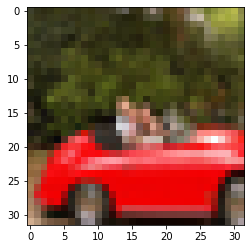

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

Normalizing the data by stacking all images and computing the mean and standard deviation per channel.

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).shape

torch.Size([3, 51200000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Use the values computed above to initialzie the `Normalize` transform.

In [ ]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [ ]:
# Compuse used to chain ToTensor and Normalize
transformed_cifar10 = datasets.CIFAR10(
   data_path, train=True, download=False,
   transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.4915, 0.4823, 0.4468),
                            (0.2470, 0.2435, 0.2616))
   ]))

transformed_cifar10_val = datasets.CIFAR10(
   data_path, train=False, download=False,
   transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.4915, 0.4823, 0.4468),
                            (0.2470, 0.2435, 0.2616))
   ]))

The images now look a bit different...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


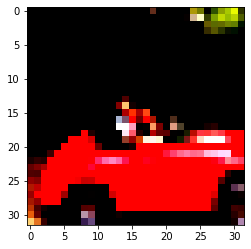

In [ ]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

We'll use just the airplane and bird pictures of the CIFAR10 data set to create a binary classifier.

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
         for img, label in transformed_cifar10
         if label in [0, 2]]
cifar2_val = [(img, label_map[label])
             for img, label in transformed_cifar10_val
             if label in [0, 2]]

We could consider each pixel in our image as in input feature to our network.  Going with this approach means that each image has 3 x 32 x 32 = 3072 input features.  

In [ ]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,
                512,
            ),
            nn.Tanh(),
            nn.Linear(
                512,
                n_out,
            )
        )

We want our network to return a vector of probabilities for each class.  We can use `nn.Softmax` to ensure each element of the vector is between 0 and 1, and that the elements of the vector have a sum of 1.

In [ ]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                 [1.0, 0.0, 5.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0179, 0.0066, 0.9756]])

In [ ]:
# Adding nn.Softmax to our model
model = nn.Sequential(
           nn.Linear(3072, 512),
           nn.Tanh(),
           nn.Linear(512, 2),
           nn.Softmax(dim=1))

We can pass an image through our model even though we have not trained the model.  In order to do so, we take our images and convert them into a 1D tensor with a length of 3072 and add a batch size to the zeroth index.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


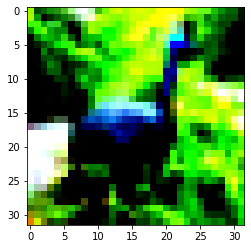

In [ ]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.size()

torch.Size([1, 3072])

In [ ]:
out = model(img_batch)
out

tensor([[0.5651, 0.4349]], grad_fn=<SoftmaxBackward0>)

Getting the index of the maximum value along our probability vector.

In [ ]:
_, index = torch.max(out, dim=1)
index

tensor([0])

We update our output module to `nn.LogSoftmax`.  Our loss function will be `nn.NLLLoss` and expects a tensor of log probabilities.  

In [ ]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

In [ ]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.6782, grad_fn=<NllLossBackward0>)

In [ ]:
import torch
import torch.nn as nn
 
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))
 
learning_rate = 1e-2
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
loss_fn = nn.NLLLoss()
 
n_epochs = 100
 
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 6.845407
Epoch: 1, Loss: 9.673444
Epoch: 2, Loss: 7.629651
Epoch: 3, Loss: 5.111976
Epoch: 4, Loss: 10.692270
Epoch: 5, Loss: 17.115112
Epoch: 6, Loss: 10.493415
Epoch: 7, Loss: 4.963921
Epoch: 8, Loss: 6.903820
Epoch: 9, Loss: 2.784739
Epoch: 10, Loss: 10.286827
Epoch: 11, Loss: 15.874063
Epoch: 12, Loss: 11.556452
Epoch: 13, Loss: 14.782986
Epoch: 14, Loss: 8.973046
Epoch: 15, Loss: 10.812085
Epoch: 16, Loss: 8.289096
Epoch: 17, Loss: 4.510077
Epoch: 18, Loss: 7.508279
Epoch: 19, Loss: 2.097273
Epoch: 20, Loss: 1.449826
Epoch: 21, Loss: 7.268541
Epoch: 22, Loss: 6.860572
Epoch: 23, Loss: 5.089981
Epoch: 24, Loss: 8.884204
Epoch: 25, Loss: 12.396263
Epoch: 26, Loss: 22.335255
Epoch: 27, Loss: 15.376911
Epoch: 28, Loss: 2.204850
Epoch: 29, Loss: 14.250476
Epoch: 30, Loss: 21.075947
Epoch: 31, Loss: 9.577251
Epoch: 32, Loss: 14.716429
Epoch: 33, Loss: 13.750503
Epoch: 34, Loss: 7.421245
Epoch: 35, Loss: 8.344542
Epoch: 36, Loss: 9.293303
Epoch: 37, Loss: 9.492724
Epoch: 

Working with the `DataLoader` constructor instead of updating our gradients after each sample.

In [ ]:
import torch
import torch.nn as nn
 
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
 
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))
 
learning_rate = 1e-2
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
loss_fn = nn.NLLLoss()
 
n_epochs = 100
 
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.437973
Epoch: 1, Loss: 0.590020
Epoch: 2, Loss: 0.334616
Epoch: 3, Loss: 0.514271
Epoch: 4, Loss: 0.526015
Epoch: 5, Loss: 0.594483
Epoch: 6, Loss: 0.434732
Epoch: 7, Loss: 0.386263
Epoch: 8, Loss: 0.348187
Epoch: 9, Loss: 0.293486
Epoch: 10, Loss: 0.232520
Epoch: 11, Loss: 0.361443
Epoch: 12, Loss: 0.420358
Epoch: 13, Loss: 0.431604
Epoch: 14, Loss: 0.280863
Epoch: 15, Loss: 0.455049
Epoch: 16, Loss: 0.196612
Epoch: 17, Loss: 0.370200
Epoch: 18, Loss: 0.245876
Epoch: 19, Loss: 0.267010
Epoch: 20, Loss: 0.238368
Epoch: 21, Loss: 0.175580
Epoch: 22, Loss: 0.345498
Epoch: 23, Loss: 0.362575
Epoch: 24, Loss: 0.229912
Epoch: 25, Loss: 0.365209
Epoch: 26, Loss: 0.217381
Epoch: 27, Loss: 0.229726
Epoch: 28, Loss: 0.202914
Epoch: 29, Loss: 0.177311
Epoch: 30, Loss: 0.269567
Epoch: 31, Loss: 0.341395
Epoch: 32, Loss: 0.640860
Epoch: 33, Loss: 0.356796
Epoch: 34, Loss: 0.174529
Epoch: 35, Loss: 0.112439
Epoch: 36, Loss: 0.273478
Epoch: 37, Loss: 0.212719
Epoch: 38, Loss: 0.182

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                        shuffle=False)

correct = 0
total = 0

with torch.no_grad():
   for imgs, labels in val_loader:
       batch_size = imgs.shape[0]
       outputs = model(imgs.view(batch_size, -1))
       _, predicted = torch.max(outputs, dim=1)
       total += labels.shape[0]
       correct += int((predicted == labels).sum())

print(correct)
print(total)
print(f"Accuracy: {correct/total}")

1638
2000
Accuracy: 0.819


Adding depth and capacity to our model in an attempt to improve performance

In [ ]:
connected_model = nn.Sequential(
           nn.Linear(3072, 1024),
           nn.Tanh(),
           nn.Linear(1024, 512),
           nn.Tanh(),
           nn.Linear(512, 128),
           nn.Tanh(),
           nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

# How many parameters is this?
numel_list = [p.numel()
             for p in connected_model.parameters()
             if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

Our model thus far is not translation invariant.  A plane in one section of the image would not allow us to detect a plane in a different area of the picture even if the plane was the same image.  Convolutions will help address this.